In [6]:
import torch
import numpy as np
from IPython.core.debugger import set_trace
import imageio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms



import importlib.util


from tkmodel.TwoCUM import TwoCUMfittingConc
from tkmodel.TwoCUM import TwoCUM

In [7]:
'''
Questions for 03/11/2021
Is my data generation okay, im worried what kind of random distribution i should use.
Should i normalise Fp to between 0 and 1 like the others?
Possibly add uncertainty to replicate the test data set a bit more?
'''

'\nQuestions for 03/11/2021\nIs my data generation okay, im worried what kind of random distribution i should use.\nShould i normalise Fp to between 0 and 1 like the others?\nPossibly add uncertainty to replicate the test data set a bit more?\n'

In [13]:
#useful functions

def plot_PK(output, true):
    AIF_plot = np.load("data/AIF.npy")
    t_plot = np.arange(0,366,2.45)
    fitted_curve = TwoCUM(output, t_plot, AIF_plot, 0)
    plt.plot(t_plot, fitted_curve, label = 'Prediction')
    fitted_curve = TwoCUM(true, t_plot, AIF_plot, 0)
    plt.plot(t_plot, fitted_curve, label = 'True')
    plt.legend()
    plt.show()
    
def generate_xy(num_curves):
    AIF = np.load("data/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    vp = np.random.rand(1,num_curves)
    Fp = 1e-5*np.random.rand(1,num_curves)
    
#     Fp = abs(np.random.normal(size=num_curves, loc= 1e-5, scale = 1e-4)[None,:])

    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)


    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y

def training_loop(x, y, epochs, plot = True):
    #x is the inputs, y is the true value of the predictions
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    loss_func = torch.nn.MSELoss()
    mean = x.mean()
    std = x.std()
    print(mean, std)
#     transform_x=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean, std)])

    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    
    torch_dataset = Data.TensorDataset(x, y) #wrapper to join x and y into one dataloader

    dataloader = Data.DataLoader(torch_dataset, batch_size=500, shuffle=True) #dataloader for batching and shuffle every epoch

    enum = epochs
    loss_list = []
    for epoch in range(enum):
        train_loss = 0

        for i, (mini_x, mini_y) in enumerate(dataloader): # take out a batch for each step
            

            prediction = net(mini_x)     # input x and predict based on x
            loss = loss_func(prediction, mini_y)
#             loss = loss_fn_batch(prediction, mini_y)
            train_loss += loss.item()

                
            optimizer.zero_grad()   # clear gradients so it doesn't stack up over the loops
            loss.backward()        # backprop

            optimizer.step() 
        
        print(len(dataloader.dataset))
        print(len(dataloader))

        train_loss /= x.shape[0]
        loss_list.append(train_loss)
        print(epoch, loss)
        if epoch%10 == 0 and plot == True:
            #plot one example of prediction vs true values
            print('Prediction, True Values')
            print(prediction[0].detach().numpy() , mini_y[0].detach().numpy())
            plot_PK(prediction[0].detach().numpy(), mini_y[0].detach().numpy())
    
    #plot the loss over epochs
    plt.plot(list(range(enum)), loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(150, 1000)   # hidden layer
        self.hidden2 = torch.nn.Linear(1000, 200)   # hidden layer
        self.hidden3 = torch.nn.Linear(200, 50)
        self.hidden4 = torch.nn.Linear(50, 300)
        self.hidden5 = torch.nn.Linear(300, 200)
        self.predict = torch.nn.Linear(200, 3)

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = self.predict(x)             # linear output
        return x
    
#example custom loss function
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,y_pred, y_true):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
print(Net())

Net(
  (hidden): Linear(in_features=150, out_features=1000, bias=True)
  (hidden2): Linear(in_features=1000, out_features=200, bias=True)
  (hidden3): Linear(in_features=200, out_features=50, bias=True)
  (hidden4): Linear(in_features=50, out_features=300, bias=True)
  (hidden5): Linear(in_features=300, out_features=200, bias=True)
  (predict): Linear(in_features=200, out_features=3, bias=True)
)


In [15]:
#maybe functions
def loss_fn(outputs, targets):
    #E, Fp, vp
    #time spacings
    t = np.arange(0,366,2.45)
    AIF = torch.from_numpy(np.load("data/AIF.npy"))

    
    #For outputs
    #First calculate the parameter Tp
    E, Fp ,vp = outputs[0], outputs[1], outputs[2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp) #adding dummy variables so it divides properly
    R=exptTp*(1-E) + E

    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_out = Fp*temp[0:len(t)]
    
    #For targets - copy pasted
    E, Fp ,vp = targets[0], targets[1], targets[2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp)
    R=exptTp*(1-E) + E
    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_targets = Fp*temp[0:len(t)]

    return torch.sum((F_out - F_targets)**2)/F_out.shape[0]

def loss_fn_batch(outputs, targets):
    #E, Fp, vp
    #time spacings
    t = np.arange(0,366,2.45)
    t = torch.tensor(t)
    
    batch_size = outputs[:,0].shape[0]
    AIF = torch.from_numpy(np.load("data/AIF.npy"))
    AIF1 = AIF.view(1, 1, -1) #reshaped for convolution

    
    #For outputs
    #First calculate the parameter Tp
    E, Fp ,vp = outputs[:,0], outputs[:,1], outputs[:,2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t[:,None]/Tp[None,:]) #adding dummy variables so it divides properly

    R=exptTp*(1-E) + E

    #Calculate the convolution
    R = torch.flip(R, (0,)).T #Reshape to fit the the convolution
    R = torch.unsqueeze(R, 1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(batch_size, -1)
    F_out = Fp.unsqueeze(-1)*temp[:,0:len(t)] #unsqueeze to match dimensions
    
    #For targets - copy pasted
    E_true, Fp_true ,vp_true = targets[:,0], targets[:,1], targets[:,2]
    Tp_true=(vp_true/Fp_true)*(1-E_true)
    #Calculate the IRF
    exptTp_true= torch.exp(-1*t[:,None]/Tp_true[None,:]) #adding dummy variables so it divides properly

    R_true=exptTp_true*(1-E_true) + E_true

    #Calculate the convolution
    R_true = torch.flip(R_true, (0,)).T #Reshape to fit the the convolution
    R_true = torch.unsqueeze(R_true, 1)
    temp_true = t[1]*torch.nn.functional.conv1d(AIF1, R_true, padding = AIF.shape[0]-1).view(batch_size, -1)
    F_targets = Fp_true.unsqueeze(-1)*temp_true[:,0:len(t)] #unsqueeze to match dimensions
    
    MSE = torch.sum((F_out - F_targets)**2)/F_out.shape[1]
    return MSE


outputs, targets = torch.Tensor([[0.5, 2e-4, 0.5],[0.4, 2e-5, 0.3]]), torch.Tensor([[0.2, 2.5e-5, 0.5],[0.1, 6e-5, 0.3]])
outputs1, targets1 = torch.Tensor([0.5, 2e-4, 0.5]), torch.Tensor([0.2, 2.5e-5, 0.5])
outputs2, targets2 = torch.Tensor([0.4, 2e-5, 0.3]), torch.Tensor([0.1, 6e-5, 0.3])

loss1 = loss_fn(outputs1, targets1)
loss2 = loss_fn(outputs2, targets2)

print('Batch')
loss = loss_fn_batch(outputs, targets)
print('batch = 2',loss, loss.shape)
print('batch = 1',loss1, loss1.shape)
print('batch = 1 second',loss2, loss2.shape)

outputs, targets = torch.DoubleTensor([[0.5, 2e-4, 0.5],[0.4, 2e-5, 0.3]]), torch.DoubleTensor([[0.2, 2.5e-5, 0.5],[0.1, 6e-5, 0.3]])
outputs.requires_grad = True
targets.requires_grad = True

torch.autograd.gradcheck(loss_fn_batch, (outputs, targets))

# outputs1, targets1 = outputs.detach().numpy(), targets.detach().numpy()
# plot_PK(outputs, targets)

Batch
batch = 2 tensor(0.0039, dtype=torch.float64) torch.Size([])
batch = 1 tensor(0.0037, dtype=torch.float64) torch.Size([])
batch = 1 second tensor(0.0002, dtype=torch.float64) torch.Size([])


True

In [16]:

def loss_fn_batch_test(outputs, targets):
    #E, Fp, vp
    #time spacings
    t = np.arange(0,366,2.45)
    t = torch.tensor(t)
    t = Variable(t)
    
    batch_size = outputs[:,0].shape[0]
    AIF = torch.from_numpy(np.load("data/AIF.npy"))
    AIF = Variable(AIF)
    AIF1 = AIF.view(1, 1, -1) #reshaped for convolution

    
    #For outputs
    #First calculate the parameter Tp
    E, Fp ,vp = outputs[:,0], outputs[:,1], outputs[:,2]
    print(E.is_leaf)
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t[:,None]/Tp[None,:]) #adding dummy variables so it divides properly
    R=exptTp*(1-E) + E
    #Calculate the convolution
    R = torch.flip(R, (0,)).T #Reshape to fit the the convolution
    R = torch.unsqueeze(R, 1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(batch_size, -1)

    F_out = Fp.unsqueeze(-1)*temp[:,0:len(t)] #unsqueeze to match dimensions
    
    #For targets - copy pasted
    E_true, Fp_true ,vp_true = targets[:,0], targets[:,1], targets[:,2]
    Tp_true=(vp_true/Fp_true)*(1-E_true)
    #Calculate the IRF
    exptTp_true= torch.exp(-1*t[:,None]/Tp_true[None,:]) #adding dummy variables so it divides properly

    R_true=exptTp_true*(1-E_true) + E_true

    #Calculate the convolution
    R_true = torch.flip(R_true, (0,)).T #Reshape to fit the the convolution
    R_true = torch.unsqueeze(R_true, 1)
    temp_true = t[1]*torch.nn.functional.conv1d(AIF1, R_true, padding = AIF.shape[0]-1).view(batch_size, -1)
    F_targets = Fp_true.unsqueeze(-1)*temp_true[:,0:len(t)] #unsqueeze to match dimensions
    
    MSE = torch.sum((F_out - F_targets)**2)/F_out.shape[1]
    
    F_targets.register_hook(lambda x: print(x))
    F_out.register_hook(lambda x: print(x))
    MSE.register_hook(lambda x: print(x))


    return MSE


outputs, targets = torch.DoubleTensor([[0.5, 2e-4, 0.5],[0.4, 2e-5, 0.3]]), torch.DoubleTensor([[0.2, 2.5e-5, 0.5],[0.1, 6e-5, 0.3]])
outputs.requires_grad = True
targets.requires_grad = True

loss = loss_fn_batch_test(outputs, targets)
loss.backward()
print(loss.grad)


False
tensor(1., dtype=torch.float64)
tensor([[ 6.1253e-07,  8.8254e-07,  1.1523e-06,  3.7805e-07,  8.1961e-07,
         -3.0827e-07, -5.5562e-07,  7.3240e-07,  6.5745e-07,  5.9639e-08,
         -1.8812e-07, -7.8499e-07,  1.6730e-07,  4.3780e-07,  5.3597e-07,
          8.0607e-07, -4.6309e-06, -3.7176e-05, -7.8609e-05, -1.1536e-04,
         -1.4412e-04, -1.6108e-04, -1.7271e-04, -1.8320e-04, -1.9193e-04,
         -2.0708e-04, -2.2246e-04, -2.3471e-04, -2.4982e-04, -2.5956e-04,
         -2.7318e-04, -2.8751e-04, -2.9765e-04, -3.1220e-04, -3.2366e-04,
         -3.3627e-04, -3.4886e-04, -3.5938e-04, -3.7242e-04, -3.8292e-04,
         -3.9570e-04, -4.0639e-04, -4.1962e-04, -4.3051e-04, -4.3855e-04,
         -4.5080e-04, -4.6280e-04, -4.7276e-04, -4.8520e-04, -4.9717e-04,
         -5.0514e-04, -5.1755e-04, -5.2949e-04, -5.4164e-04, -5.5042e-04,
         -5.6209e-04, -5.7193e-04, -5.8267e-04, -5.9272e-04, -6.0320e-04,
         -6.1436e-04, -6.2371e-04, -6.3439e-04, -6.4416e-04, -6.5415e-04,


/var/folders/2m/v5d7mznx1v39h5mv6nwjnvxm0000gn/T/ipykernel_2682/127298649.py:59: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(loss.grad)


0.0015638963878833838 0.0014136484600740405
100000
200
0 tensor(0.1534, grad_fn=<MseLossBackward>)
Prediction, True Values
[0.10727516 0.03277105 0.14202636] [6.7778534e-01 9.8082237e-06 7.9503864e-01]


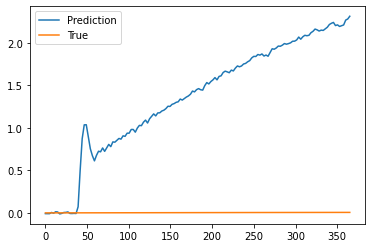

100000
200
1 tensor(0.1196, grad_fn=<MseLossBackward>)
100000
200
2 tensor(0.0964, grad_fn=<MseLossBackward>)
100000
200
3 tensor(0.0773, grad_fn=<MseLossBackward>)
100000
200
4 tensor(0.0658, grad_fn=<MseLossBackward>)
100000
200
5 tensor(0.0660, grad_fn=<MseLossBackward>)
100000
200
6 tensor(0.0582, grad_fn=<MseLossBackward>)
100000
200
7 tensor(0.0597, grad_fn=<MseLossBackward>)
100000
200
8 tensor(0.0570, grad_fn=<MseLossBackward>)
100000
200
9 tensor(0.0574, grad_fn=<MseLossBackward>)
100000
200
10 tensor(0.0572, grad_fn=<MseLossBackward>)
Prediction, True Values
[0.46711564 0.00267155 0.46967283] [2.4187252e-01 3.3697693e-06 1.6639161e-01]


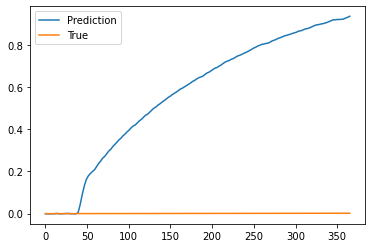

KeyboardInterrupt: 

In [17]:
x, y = generate_xy(10000)
net = Net()

training_loop(x ,y ,epochs=100)

In [276]:
# np.save('data_adam', x[:100])
# np.save('targets_adam', y[:100])


In [274]:
# f = 'net.pt'
# torch.save(net.state_dict(), f)